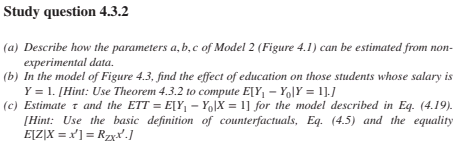
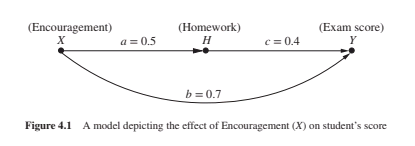

Here we have a simple SCM:

In [12]:
import warnings
warnings.filterwarnings('ignore')

a = 0.5
b = 0.7
c = 0.4

import numpy as np

def regress(vars, target, sample):
    target_data = sample[target]
    data = np.zeros([len(vars), target_data.shape[0]])
    for i, var in enumerate(vars):
        data[i] = sample[var]
    return np.linalg.lstsq(data.T, sample[target])[0]

def get_sample(N=1_000_000, a=a, b=b, c=c):
    X = np.random.normal(0, 1, N)
    U_H = np.random.normal(0, 1, N)
    U_Y = np.random.normal(0, 1, N)
    H = X * a + U_H
    Y = b * X + H * c + U_Y
    return {
        "X": X,
        "H": H,
        "Y": Y,
    }

sample = get_sample()

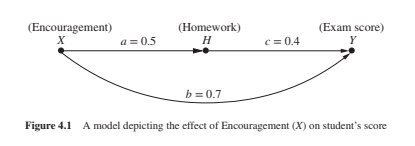

**4.3.2(a)**

$c$ can be estimated by regressing $Y$ against both $X$ and $H$, since that blocks all backdoor paths from $Y$ to $H$:

In [13]:
# 4.3.2(a)
c_est = regress(["X", "H"], "Y", sample=sample)[1]
print(f"({c_est}) ≈ ({c=})?")

(0.40046192491751925) ≈ (c=0.4)?


$a$ can be estimated by regressing $H$ against $X$:

In [16]:
a_est = regress(["X"], "H",  sample=sample)[0]
print(f"({a_est}) ≈ ({a=})?")

(0.5002326510623956) ≈ (a=0.5)?


Or by regressing $X$ against $H$, where the regression coefficient $R_{XH}:=R=\frac{a}{1+a^2}$ (see solution to 4.3.1(a), using the quadratic formula:
$$\begin{align}
R &= \frac{a}{1+a^2} \\
R + Ra^2 &= a \\
Ra^2 -a + R &= 0 \\
a &= \frac{1 \pm \sqrt{1 - 4 \cdot R \cdot R}}{2R} \\
\end{align}$$

In [17]:
R = regress(["H"], "X", sample=sample)[0]
d = np.sqrt(1 - 4 * R ** 2)
a_est_2 = [(1 + d) / (2 * R), (1 - d) / (2 * R)]
print(f"({a_est_2}) ≈ ({a=})?")

([2.000668911874313, 0.4998328279431088]) ≈ (a=0.5)?


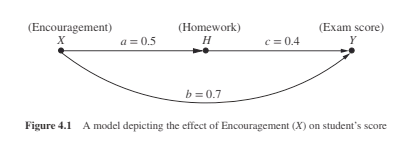

To estimate $b$, we can regress $S:=Y-H\cdot c_{est}$ against $X$:

In [23]:
b_est = regress(["X"], "S", sample={**sample, "S": sample['Y'] - (sample['H'] * c_est)})[0]
print(f"({b_est}) ≈ ({b=})?")

(0.7000035057167321) ≈ (b=0.7)?


In [25]:
b_est_bad = regress(["X", "H"], "Y", sample=sample)[0]
print(f"({b_est_bad=}) ≈ ({b=})?")

(b_est_bad=0.7000035057167311) ≈ (b=0.7)?


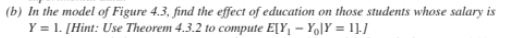
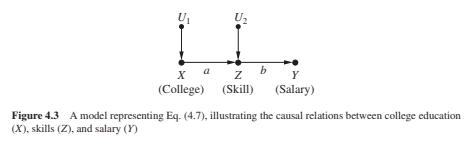
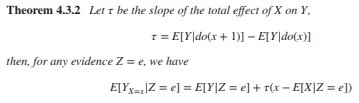

**4.3.2(b)** 

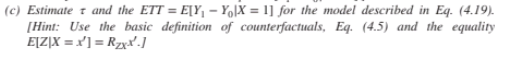

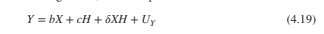

### Useful theorems
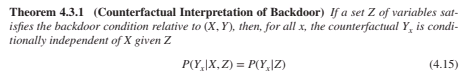

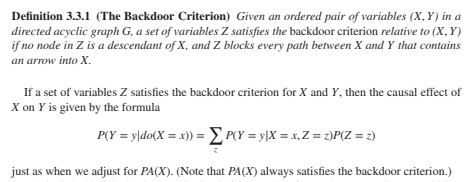
Recall that a path is blocked by $Z$ when the path contains a collider not in $Z$ and has no descendants in $Z$, or a chain/fork whose middle node is in $Z$.

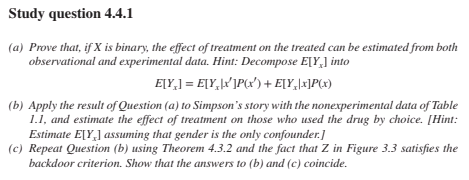

Here: $X$ is joining, and $Y$ is hiring. The subscripts denote $X$. Recall the definition:
$$ ETT = E[Y_1 - Y_0|X=1] $$

$$\begin{align}
    ETT &= E[Y_1 - Y_0|X=1] \\
        &= E[Y_1|X=1] - E[Y_0|X=1] \\
        &= E[Y|do(X=1), X=1] - E[Y|do(X=0), X=1] \\
\end{align}$$

Now note that:
$$\begin{align}
    E[Y_1] &= E[Y|do(X=1), X=1] + E[Y|do(X=0), X=1] \qquad\textrm{but also:}\\
           &= E[Y_1|X=0]P(X=0) + E[Y_1|X=1]P(X=1) \qquad\textrm{(by the hint)}
\end{align}$$

$$\begin{align}
    E[Y_1] &= E[Y|do(X=1), X=1] + E[Y|do(X=0), X=1] \qquad\textrm{but also:}\\
           &= E[Y_1|X=0]P(X=0) + E[Y_1|X=1]P(X=1) \qquad\textrm{(by the hint)}
\end{align}$$



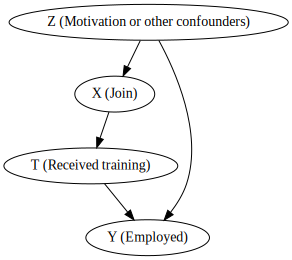

In [27]:
import pygraphviz as pgv
from IPython.display import Image, SVG, display
import networkx as nx

def draw(graph):
    svg = nx.nx_agraph.to_agraph(graph).draw(prog='dot',format='svg')
    display(SVG(svg))
    
import networkx as nx
def draw_diag():
    G = nx.DiGraph()
    X = "X (Join)"
    Y = "Y (Employed)"
    T = "T (Received training)"
    M = "Z (Motivation or other confounders)"
    G.add_edge(X, T)
    G.add_edge(T, Y)
    G.add_edge(M, X)
    G.add_edge(M, Y)

    draw(G)
draw_diag()